#### Ciencia de datos - Primavera 2024
##### Integrantes: Magdalena Cobb, Pedro García Vassallo, Marcos Olavarría
### Trabajo Práctico 4

## 1. Lectura de la base

In [5]:
#Paquetes y librerías a usar
#!pip install openpyxl
#!pip install statsmodels

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay
#from sklearn.metrics import plot_roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier

In [6]:
#Lectura del documento
indi_2024 = pd.read_excel('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/usu_individual_T124.xlsx') 
indi_2004 = pd.read_stata('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/Individual_t104.dta')
hoga_2024 = pd.read_excel('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/usu_hogar_T124.xlsx')
hoga_2004 = pd.read_stata('C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/Hogar_t104.dta')

# Maggie: C:/Users/magda/OneDrive/Documents/GitHub/CC408-T1-5/TP 4/
# Peter: 'C:/Users/SAMSUNG/Documents/GitHub/CC408-T1-5/TP 4/
# Marck: C:/Users/marcos.olavarria/Documents/GitHub/CC408/TP 4/


## 2. Selección de GBA y merge

a. Eliminen todas las observaciones que no corresponden a los
aglomerados de Ciudad Autónoma de Buenos Aires o Gran Buenos
Aires, y unan ambos trimestres en una sola base.

In [606]:
#Filtramos las bases para tener solo Buenos Aires
ind_2024 = indi_2024[(indi_2024['AGLOMERADO'] == 33) | (indi_2024['AGLOMERADO'] == 32)]
hog_2024 = hoga_2024[(hoga_2024['AGLOMERADO'] == 33) | (hoga_2024 ['AGLOMERADO'] == 32 )]

ind_2004 = indi_2004[(indi_2004['aglomerado'] == 'Ciudad de Buenos Aires') | (indi_2004 ['aglomerado'] == 'Partidos del GBA' )]
hog_2004 = hoga_2004[(hoga_2004['aglomerado'] == 'Ciudad de Buenos Aires') | (hoga_2004 ['aglomerado'] == 'Partidos del GBA' )]

ind_2004.columns = ind_2004.columns.str.upper()
hog_2004.columns = hog_2004.columns.str.upper()


In [607]:
#Eliminación de columnas redundantes (preguntas hechas solo para ocupados o desocupados)
redundantes_ind04 = [
    "CAT_INAC",
    "PP08D1", "PP08D4", "PP08F1", "PP08F2", "PP08J1", "PP08J2", "PP08J3",
    "PP11A", "PP11B_COD", "PP11B1", "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA", "PP11C", "PP11C99", "PP11D_COD",
    "PP11G_ANO", "PP11G_MES", "PP11G_DIA", "PP11L", "PP11L1", "PP11M", "PP11N", "PP11O", "PP11P", "PP11Q", "PP11R", 
    "PP11S", "PP11T", "PP02C1", "PP02C2", "PP02C3", "PP02C4", "PP02C5", "PP02C6", "PP02C7", "PP02C8", "PP02E", 
    "PP02H", "PP02I", "CAT_OCUP", "PP03C", "PP03D", "PP3E_TOT", "PP3F_TOT", "PP03G", "PP03H", "PP03I", "PP03J", 
    "INTENSI", "PP04A", "PP04B_COD", "PP04B1", "PP04B2", "PP04B3_MES", "PP04B3_ANO", "PP04B3_DIA", "PP04C", 
    "PP04C99", "PP04D_COD", "PP04G", "PP05B2_MES", "PP05B2_ANO", "PP05B2_DIA", "PP05C_1", "PP05C_2", "PP05C_3", 
    "PP05E", "PP05F", "PP05H", "PP06A", "PP06C", "PP06E", "PP06H", "PP06D", "PP07A", "PP07C", "PP07D", "PP07E", "PP07F1", "PP07F2", 
    "PP07F3", "PP07F4", "PP07F5", "PP07G1", "PP07G2", "PP07G3", "PP07G4", "PP07G_59", "PP07H", "PP07I", "PP07J", 
    "PP07K", "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR", "TOT_P12", "PJ1_1", 
    "PJ2_1", "PJ3_1", "IDIMPP", 'PP09A', 'PP09A_ESP',  'PP09B', 'PP09C',  'PP09C_ESP',  'PP10A','PP10C',  'PP10D', 'PP10E', 
    'CH15_COD', 'CH16_COD', 'IDECINDR', 'PDECINDR', 'IDECCFR', 'PDECCFR']

redundantes_hog04 = [
    "II3",
    "II3_1",
    "II6",
    "II6_1", 
    'IDIMPH' , 'IV1_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP', 'IDECIFR', 'PDECIFR', 'IDECCFR', 'PDECCFR', 'MAS_500'
]

redundantes_ind24 = [
    "PP02C1", "PP02C2", "PP02C3", "PP02C4", "PP02C5", "PP02C6", "PP02C7", "PP02C8",
    "PP02E", "PP02H", "PP02I", "PP10A", "PP10C", "PP10D", "PP10E", "PP11A",
    "PP11B_COD", "PP11B1", "PP11B2_MES", "PP11B2_ANO", "PP11B2_DIA", "PP11C", 
    "PP11C99", "PP11D_COD", "PP11G_ANO", "PP11G_MES", "PP11G_DIA", "PP11L", "PP11L1",
    "PP11M", "PP11N", "PP11O", "PP11P", "PP11Q", "PP11R", "PP11S", "PP11T",
    "PP03C", "PP03D", "PP3E_TOT", "PP3F_TOT", "PP03G", "PP03H", "PP03I", "PP03J",
    "INTENSI", "PP04A", "PP04B_COD", "PP04B1", "PP04B2", "PP04B3_MES", "PP04B3_ANO",
    "PP04C", "PP04C99", "PP04D_COD", "PP04G", "PP05B2_MES", "PP05B2_ANO", "PP05B2_DIA", 'PP04B3_DIA',
    "PP05C_1", "PP05C_2", "PP05C_3", "PP05E", "PP05F", "PP05H", "PP06A", "PP06C",
    "PP06D", "PP06E", "PP06H", "PP07A", "PP07C", "PP07D", "PP07E", "PP07F1", "PP07F2",
    "PP07F3", "PP07F4", "PP07F5", "PP07G1", "PP07G2", "PP07G3", "PP07G4", "PP07G_59",
    "PP07H", "PP07I", "PP07J", "PP07K", "PP08D1", "PP08D4", "PP08F1", "PP08F2", 
    "PP08J1", "PP08J2", "PP08J3", "PP09A", "PP09A_ESP", "PP09B", "PP09C", "PP09C_ESP",
    "P21", "DECOCUR", "IDECOCUR", "RDECOCUR", "GDECOCUR", "PDECOCUR", "ADECOCUR",
    "PONDIIO", "TOT_P12", "P47T", "DECINDR", "IDECINDR", "RDECINDR", "GDECINDR", 
    "PDECINDR", "ADECINDR", "PONDII",  'PP10A',  'PP10C', 'PP10D',  'PP10E', 'CH15_COD', 'CH16_COD', 
    'IDECINDR', 'PDECINDR', 'IDECCFR', 'PDECCFR', 'CH05'
]

redundantes_hog24 = [
    "II3",
    "II3_1",
    "II6",
    "II6_1", 'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP','IDECIFR', 'PDECIFR', 'IDECCFR', 'PDECCFR', 'MAS_500'

]



In [608]:
#Sacamos las variables redundantes
ind_2004 = ind_2004.drop(columns = redundantes_ind04)
ind_2024 = ind_2024.drop(columns = redundantes_ind24)
hog_2004 = hog_2004.drop(columns = redundantes_hog04)
hog_2024 = hog_2024.drop(columns = redundantes_hog24)

In [609]:
#Sacamos de las bases individuales variables que van a aparecer en hogar, para emprolijar el merge
lista_con = ['ANO4', 'TRIMESTRE', 'REGION',  'AGLOMERADO', 'PONDERA', 'ITF', 'DECIFR', 'IDECIFR', 
             'RDECIFR', 'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR','ADECCFR']

lista_con2 = ['ANO4', 'TRIMESTRE', 'REGION', 'AGLOMERADO', 'PONDERA', 'ITF', 'DECIFR', 'IDECIFR', 'RDECIFR',
              'GDECIFR', 'PDECIFR', 'ADECIFR', 'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR', 'ADECCFR','PONDIH']

ind_2004 = ind_2004.drop (columns = (lista_con))
ind_2024 = ind_2024.drop(columns = (lista_con2))

In [610]:
#Mergeamos bases hogar + individual para cada año
combined_04 = pd.merge(ind_2004, hog_2004, on=['CODUSU', 'NRO_HOGAR'], how='outer') #7647 obs x 124 variables
combined_24 = pd.merge(ind_2024,hog_2024,on=["CODUSU","NRO_HOGAR"], how = 'outer') #7051 obs x 120 variables


## 3. Limpieza
Limpien la base de datos tomando criterios que hagan sentido. Explicar
cualquier decisión como el tratamiento de valores faltantes (missing
values), extremos (outliers), o variables categóricas. Justifique sus
decisiones.

In [611]:
# Se usa base de datos:
# 2024: 
# - combined_24

# 2004:
# - combined_04

##### Limpieza de datos

In [612]:
#Elimino filas con valores negativos para 2004
combined_04_clean = combined_04[~(combined_04.select_dtypes(include=[float, int]) < 0).any(axis=1)]
combined_04 = combined_04_clean

#Elimino filas con valores negativos para 2024
combined_24_clean = combined_24[~(combined_24.select_dtypes(include=[float, int]) < 0).any(axis=1)]
combined_24 = combined_24_clean


In [613]:
# ELIMINO OBSERVACIONES QUE CONTESTAN "NO SABE/ NO RESPONDE" PARA ALGUNAS PREGUNTAS DEL HOGAR. base 2004
# ns_nr = (combined_04.select_dtypes(include=[int]) == 288405).any(axis=1)
# ns_nr[ns_nr]

# combined_04_cleannsnr = combined_04[~(combined_04.select_dtypes(include=['object']) == 'Ns./Nr.').any(axis=1)]
# combined_04 = combined_04_cleannsnr


#### Valores Faltantes
- 2004 tenía 1 columna, se imputaron por la mediana
- 2024 se eliminaron los más brutos y se imputaron por la mediana los menos

##### 2004
-Tenia una columna con valores Nan = IX_MEN10, es el 50%, se imputa por la mediana.


In [614]:
# # Verificar si cada columna tiene algún valor NaN 2004
nan_values04 = combined_04.select_dtypes(include=[float, int]).isna().any()
columnas_con_nan04 = nan_values04[nan_values04]  # Esto te devuelve solo las columnas que tienen NaN
columnas_con_nan04 = columnas_con_nan04.index
print(columnas_con_nan04) #Es solo una columna con NaN

combined_04 = combined_04.drop(columns = (columnas_con_nan04))

Index(['IX_MEN10'], dtype='object')


In [615]:
# proporcion_columna04 = combined_04['IX_MEN10'].isnull().sum() / len(combined_04) * 100
# proporcion_columna04 #El 50% de la columna es nan. puedo imputar por la mediana. 

# #Se imputa por la mediana
# combined_04[columnas_con_nan04] = combined_04[columnas_con_nan04].fillna(combined_04[columnas_con_nan04].median())

##### 2024
- Tiene columnas con valores Nan
- Se revisa la proporción de Nan que hay por columna
- Elimino las columnas que tienen proporción de Nans > 90
- Imputo por la mediana en las columnas que su proporción de Nans < 90

In [616]:
# # Verificar si cada columna tiene algún valor NaN 2024
nan_values24 = combined_24.isna().any()

# # Filtrar las columnas que contienen valores NaN (solo mostrar las que son True)
columnas_con_nan24 = nan_values24[nan_values24] # Esto te devuelve solo las columnas que tienen NaN

print(columnas_con_nan24)

columnas_con_nan24 = columnas_con_nan24.index


CH14      True
IMPUTA    True
dtype: bool


In [617]:
#Elimino de la base de 2024 todas las columnas que tienen 
# combined_24 = combined_24.drop(columns = ["CH14", "CH15_COD", "CH16_COD", "IMPUTA", "PP04B3_DIA", "IDECIFR", "PDECIFR", "IDECCFR",'IV1_ESP', 'IV3_ESP', 'IV7_ESP', 'II7_ESP', 'II8_ESP'])

In [618]:
# # Obtengo las columnas que contienen datos faltantes, reviso que proporción de los valores faltas

# # Porcentaje de valores faltantes por columna
lista_nans_poco = []
lista_nans_50 = []
lista_nans_60 = []
lista_nans_70 = []
lista_nans_80 = []
lista_nans_90 = []
lista_nans_100 = []

for i in columnas_con_nan24:
    proporcion_columna24 = combined_24[i].isnull().sum() / len(combined_24) * 100
    
    if proporcion_columna24 < 50:
        lista_nans_poco.append(i)

    elif proporcion_columna24 >= 50 and proporcion_columna24 < 60:
        lista_nans_50.append(i)

    elif proporcion_columna24 >= 60 and proporcion_columna24 < 70:
        lista_nans_60.append(i)

    elif proporcion_columna24 >= 70 and proporcion_columna24 < 80:
        lista_nans_70.append(i)

    elif proporcion_columna24 >= 80 and proporcion_columna24 < 90:
        lista_nans_80.append(i)

    elif proporcion_columna24 >= 90 and proporcion_columna24 < 100:
        lista_nans_90.append(i)

    elif proporcion_columna24 == 100:
        lista_nans_100.append(i)
    

In [619]:
# Elimino las variables que tienen más de 90% de datos Nan. Me fijo antes cuantas columnas son
columnas_elim = lista_nans_90 + lista_nans_100
combined_24 = combined_24.drop(columns = (columnas_elim)) #se eliminaron ? columnas

In [620]:
# Imputo por la mediana en las columnas que su proporción de Nans < 90
columnas_ok = lista_nans_poco + lista_nans_50 +lista_nans_60 + lista_nans_70 + lista_nans_80
combined_24[columnas_ok] = combined_24[columnas_ok].fillna(combined_24[columnas_ok].median())


In [621]:
#AHORA VEMOS QUE NO HAY MAS NANS EN LA DE 2024
nan_values24 = combined_24.isna().any()

# # Filtrar las columnas que contienen valores NaN (solo mostrar las que son True)
columnas_con_nan24 = nan_values24[nan_values24] # Esto te devuelve solo las columnas que tienen NaN

print(columnas_con_nan24)

columnas_con_nan24 = columnas_con_nan24.index


Series([], dtype: bool)


### Outliers 

#### 2004

In [622]:
numerica04 = [ 'P47T','IV2', 'V2_M', 'V3_M', 'V4_M', 'V5_M', 'V8_M',
                    'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM', 'V21_M', 'T_VI',
                       'PONDERA', 'II5_1', 'IX_TOT', 'IX_MAYEQ10', 'ITF']


#es igual que no categorica pero sin codusu, porque no tiene sentido sacar outliers de ahi. 
#estoy sacando COMPONENTE , CH06, CH04, ESTADO xq son tipo de dato category 
# 'REALIZADA', 'TRIMESTRE', 'REGION', 'AGLOMERADO', 'IV2', 'II1', 'II2',
      # 'VII1_1', 'VII1_2', 'VII2_1', 'VII2_2', 'VII2_3', 'VII2_4', 'H15', 'V1',
      # 'V2', 'V21', 'V22', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
      # 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19_A',
      # 'V19_B', 'II4_1', 'IV8', 'IV12_2', 'IV12_3', 'IV12_1', 'II4_2', 'II4_3',
      # 'CH13', 'II5', 'IV5', 'REALIZADA', 'TRIMESTRE', 'AGLOMERADO', 'REGION', 'II1','II2', 'IV2'

# y saque NRO HOGAR

#es igual que no categorica pero sin codusu, porque no tiene sentido sacar outliers de ahi. 

In [623]:
# Verifica el tipo de datos de todas las columnas en el DataFrame
print(combined_04[numerica04].dtypes)

# Filtrar las columnas que son de tipo 'category'
categorical_columns = combined_04[numerica04].select_dtypes(include=['object']).columns

# Mostrar las columnas que son de tipo 'category'
print(f"Columnas de tipo 'object': \n{categorical_columns}")

P47T           float64
IV2           category
V2_M           float64
V3_M           float64
V4_M           float64
V5_M           float64
V8_M           float64
V9_M           float64
V10_M          float64
V11_M          float64
V12_M          float64
V18_M          float64
V19_AM         float64
V21_M          float64
T_VI           float64
PONDERA        float64
II5_1          float64
IX_TOT         float64
IX_MAYEQ10     float64
ITF            float64
dtype: object
Columnas de tipo 'object': 
Index([], dtype='object')


In [624]:
# Outliers
# COMBINED 04

combined_04[numerica04] = combined_04[numerica04].apply(pd.to_numeric, errors='coerce')

# Calculamos los cuartiles y el IQR solo para las columnas numéricas
Q1 = combined_04[numerica04].quantile(0.1)
Q3 = combined_04[numerica04].quantile(0.9)
IQR = Q3 - Q1

# Definir los límites inferior y superior
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Detectar outliers (donde los valores están fuera de los límites)
outliers = (combined_04[numerica04] < lower_limit) | (combined_04[numerica04] > upper_limit)

# Mostrar una vista de los outliers por fila
outliers_data = combined_04[outliers.any(axis=1)]

# Opcional: Mostrar el total de outliers por columna
outliers_count = outliers.sum()
print(f"Total de outliers por columna: \n{outliers_count}")

# Mostrar las filas que contienen outliers
print(f"Filas con outliers: \n{outliers_data}")

# Eliminar filas con outliers
combined_04_no_outliers = combined_04[~outliers.any(axis=1)]

combined_04 = combined_04_no_outliers

Total de outliers por columna: 
P47T          110
IV2            36
V2_M          764
V3_M            8
V4_M           13
V5_M          107
V8_M           71
V9_M            8
V10_M          15
V11_M          13
V12_M         229
V18_M           5
V19_AM          0
V21_M         107
T_VI          231
PONDERA        56
II5_1          76
IX_TOT         15
IX_MAYEQ10     14
ITF            87
dtype: int64
Filas con outliers: 
        CODUSU  NRO_HOGAR COMPONENTE H15 MAS_500            CH03   CH04  CH06  \
0     125047          1.0        1.0  Sí       S            Jefe  Varón  80.0   
1     125047          1.0        2.0  Sí       S  Cónyuge/Pareja  Mujer  75.0   
2     125098          1.0        1.0  Sí       S            Jefe  Varón  79.0   
13    125295          1.0        1.0  Sí       S            Jefe  Varón  34.0   
17    125511          1.0        1.0  Sí       S            Jefe  Mujer  75.0   
...        ...        ...        ...  ..     ...             ...    ...   ...   
7584  2

#### 2024

In [625]:
#Lista de todas las variables de la base 2004
lista04 = combined_04.columns.to_list()
len(lista04)

109

In [626]:
# #Para la base 2004, reemplazo los valores de texto de las variables binarias a 0 y 1 para ya usarlas como dummies. 
# reemplazosbinarias = {
#     "Sí" : 1, 
#     "No" : 0, 
#     "S" : 1, 
#     "N" : 0, 
#     "Varón" : 1, 
#     "Mujer" : 0
# }

# combined_04 = combined_04.applymap(lambda x: reemplazosbinarias.get(x, x))

In [627]:
#variables numericas para sacar outliers
numerica24 = ['CH06', 'ESTADO', 'V2_M', 
                  'V3_M', 'V4_M', 'V5_M', 'V8_M', 'V9_M', 'V10_M', 'V11_M', 'V12_M', 'V18_M', 'V19_AM',
                    'V21_M', 'T_VI', 'II1', 'II2', 'II5_1', 
                        'IX_TOT', 'IX_MEN10', 'IX_MAYEQ10', 'ITF', 'DECIFR', 'RDECIFR', 'GDECIFR', 'ADECIFR',
                          'IPCF', 'DECCFR', 'RDECCFR', 'GDECCFR', 'ADECCFR', 'PONDIH', 'IV2']

In [628]:
# Verifica el tipo de datos de todas las columnas en el DataFrame
print(combined_24[numerica24].dtypes)

# Filtrar las columnas que son de tipo 'category'
categorical_columns = combined_24[numerica24].select_dtypes(include=['object']).columns

# Mostrar las columnas que son de tipo 'category'
print(f"Columnas de tipo 'object': \n{categorical_columns}")

CH06            int64
ESTADO          int64
V2_M            int64
V3_M            int64
V4_M            int64
V5_M            int64
V8_M            int64
V9_M            int64
V10_M           int64
V11_M           int64
V12_M           int64
V18_M           int64
V19_AM          int64
V21_M           int64
T_VI            int64
II1             int64
II2             int64
II5_1           int64
IX_TOT          int64
IX_MEN10        int64
IX_MAYEQ10      int64
ITF             int64
DECIFR          int64
RDECIFR         int64
GDECIFR       float64
ADECIFR         int64
IPCF          float64
DECCFR          int64
RDECCFR         int64
GDECCFR       float64
ADECCFR         int64
PONDIH          int64
IV2             int64
dtype: object
Columnas de tipo 'object': 
Index([], dtype='object')


In [629]:
#outliers 2024
combined_24[numerica24] = combined_24[numerica24].apply(pd.to_numeric, errors='coerce')

# Calculamos los cuartiles y el IQR solo para las columnas numéricas
Q1 = combined_24[numerica24].quantile(0.1)
Q3 = combined_24[numerica24].quantile(0.9)
IQR = Q3 - Q1

# Definir los límites inferior y superior
lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

# Detectar outliers (donde los valores están fuera de los límites)
outliers24 = (combined_24[numerica24] < lower_limit) | (combined_24[numerica24] > upper_limit)

# Mostrar una vista de los outliers por fila
outliers_data24 = combined_24[outliers24.any(axis=1)]

# Opcional: Mostrar el total de outliers por columna
outliers_count24 = outliers24.sum()
print(f"Total de outliers por columna: \n{outliers_count24}")

# Eliminar filas con outliers
combined_24_no_outliers = combined_24[~outliers24.any(axis=1)]
combined_24 = combined_24_no_outliers

Total de outliers por columna: 
CH06            0
ESTADO          0
V2_M          149
V3_M           11
V4_M            3
V5_M          260
V8_M           70
V9_M            1
V10_M          56
V11_M          68
V12_M         155
V18_M           7
V19_AM          0
V21_M         438
T_VI          113
II1            23
II2             0
II5_1          62
IX_TOT          0
IX_MEN10       12
IX_MAYEQ10      0
ITF            86
DECIFR          0
RDECIFR         0
GDECIFR         0
ADECIFR         0
IPCF          101
DECCFR          0
RDECCFR         0
GDECCFR         0
ADECCFR         0
PONDIH         14
IV2            24
dtype: int64


### Variables categoricas

#### 2004

In [630]:
#Armo una lista con todas las variables que no quiero que sean dummies. Incluye numercias continuas y binarias (0,1).
nocategorica04 = ['CODUSU',
 'NRO_HOGAR',
 'COMPONENTE',
 'CH06',
 'ESTADO', #Estado es categorica, pero lo dejo porque despues vamos a usar una dummy de desocupado directamente. 
 'P47T',
 'DECINDR',
 'RDECINDR',
 'GDECINDR',
 'ADECINDR',
 'V2_M',
 'V3_M',
 'V4_M',
 'V5_M',
 'V8_M',
 'V9_M',
 'V10_M',
 'V11_M',
 'V12_M',
 'V18_M',
 'V19_AM',
 'V21_M',
 'T_VI',
 'REALIZADA',
 'ANO4',
 'TRIMESTRE',
 'REGION',
 'AGLOMERADO',
 'PONDERA',
 'IV2',
 'II1',
 'II2',
 'II5_1',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'ITF',
 'DECIFR',
 'RDECIFR',
 'GDECIFR',
 'ADECIFR',
 'IPCF',
 'DECCFR',
 'RDECCFR',
 'GDECCFR',
 'ADECCFR']

len(nocategorica04)

46

In [631]:
#Armo una lista de las variables categoricas para hacer dummies. Son todas las variables menos las binarias y las numericas continuas. 
categorica04 = list(set(lista04) - set(nocategorica04))
len(categorica04)

64

In [632]:
#Elimina categorias sin usar para que el get dummies no sea redundante
for i in categorica04: 
    combined_04[i] = combined_04[i].astype('category')
    combined_04[i] = combined_04[i].cat.remove_unused_categories()

In [633]:
# # dummies04 = pd.get_dummies(combined_04[categorica04], drop_first=True)
# dummies04 = pd.get_dummies(combined_04[categorica04])
# combined_04_cat = pd.concat([combined_04, dummies04], axis = 1)

# ### combined_04_cat ----- incluye dummies Y las variables originales. 

In [634]:
combined_04_total = combined_04

In [635]:
combined_04 = pd.get_dummies(combined_04, columns = categorica04, drop_first=True)

In [636]:
combined_04['CH06'] = combined_04['CH06'].replace('Menos de 1 año', 0)
combined_04['CH06'] = combined_04['CH06'].replace('98 y más años', 100)
combined_04['CH06'] = combined_04['CH06'].astype(int)

C:\Users\magda\AppData\Local\Temp\ipykernel_10220\1632687978.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  combined_04['CH06'] = combined_04['CH06'].replace('Menos de 1 año', 0)
C:\Users\magda\AppData\Local\Temp\ipykernel_10220\1632687978.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  combined_04['CH06'] = combined_04['CH06'].replace('98 y más años', 100)
C:\Users\magda\AppData\Local\Temp\ipykernel_10220\1632687978.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a futur

In [637]:
col_transform = ['IV2', 'II1', 'II2']
for i in col_transform: 
    combined_04[i] = combined_04[i].astype(str)
    combined_04[i] = combined_04[i].astype(float)
    combined_04[i] = combined_04[i].astype(int)


#### 2024

In [638]:
#Lista de todas las variables de la base 2024
lista24 = combined_24.columns.to_list()
len(lista24)

107

In [639]:
#misma lista para 2024. variables numericas continuas (que no quiero convertir en dummies)
nocategorica24 = ['CODUSU',
 'NRO_HOGAR',
 'COMPONENTE',
 'CH06',
 'ESTADO',
 'V2_M',
 'V3_M',
 'V4_M',
 'V5_M',
 'V8_M',
 'V9_M',
 'V10_M',
 'V11_M',
 'V12_M',
 'V18_M',
 'V19_AM',
 'V21_M',
 'T_VI',
 'ANO4',
 'TRIMESTRE',
 'REALIZADA',
 'REGION',
 'AGLOMERADO',
 'PONDERA',
 'II1',
 'II2',
 'II5_1',
 'IX_TOT',
 'IX_MEN10',
 'IX_MAYEQ10',
 'ITF',
 'DECIFR',
 'RDECIFR',
 'GDECIFR',
 'ADECIFR',
 'IPCF',
 'DECCFR',
 'RDECCFR',
 'GDECCFR',
 'ADECCFR',
 'PONDIH', 'IV2']

In [640]:
#Armo una lista de las variables categoricas para hacer dummies. Son todas las variables menos las binarias y las numericas continuas. 
categorica24 = list(set(lista24)- set(nocategorica24))
len(categorica24)

65

In [641]:
#Convierto los valores de las columnas categoricas a objetos para poder hacer dummies
for i in categorica24: 
    combined_24[i] = combined_24[i].astype('category')
    combined_24[i] = combined_24[i].cat.remove_unused_categories()

In [642]:
combined_24_total = combined_24

In [643]:
combined_24 = pd.get_dummies(combined_24, columns = categorica24, drop_first=True)

In [644]:
# dummies24 = pd.get_dummies(combined_24[categorica24])
# combined_24_cat = pd.concat([combined_24, dummies24], axis = 1)

# ### combined_24_cat ----- incluye dummies Y las variables originales. 
# # combined_24 = combined_24_cat.drop(columns = categorica24)

## 4. Analisis exploratorio
VARIABLES EXTRA, DESCRIPCION

In [645]:
#DEFINIR VARIABLES EXTRA
# Crear una nueva columna 'desocupado' con base en la condición ESTADO = 2
combined_04['desocupado'] = combined_04['ESTADO'] == 'Desocupado'
combined_24['desocupado'] = combined_24['ESTADO'] == 2

# Convertir valores booleanos a num
combined_04['desocupado'] = combined_04['desocupado'].map({True:1, False: 0})
combined_24['desocupado'] = combined_24['desocupado'].map({True:1, False: 0})


In [646]:
#DEFINIR VARIABLES EXTRA para cada ano

# Verificar el resultado
#NSE - con ingreso. agrupar variables  IPCF
# bins = [0, 3000, 5000, 7000, 10000] 
# labels = ['Bajo', 'Medio-Bajo', 'Medio', 'Alto']
# combined_04['ingreso_agrupado'] = pd.cut(df['ingreso'], bins=bins, labels=labels, right=False
                                         
#subsidios V5, V12, V19_A (MENORES DE 10 AÑOS)

In [647]:
#PROXY DE NIVEL SOCIOECONOMICO: INGRESO AGRUPADO
# Definir la función para categorizar los valores de DECCFR
def categorizar_nse(deccfr):
    deccfr_int = int(deccfr)
    if deccfr_int >= 0 and deccfr_int <= 3:
        return 'bajo'
    elif deccfr_int >= 4 and deccfr_int <= 7:
        return 'medio'
    elif deccfr_int >= 8:
        return 'alto'

# Aplicar la función para crear la nueva variable NSE
combined_04['NSE'] = combined_04['DECCFR'].apply(categorizar_nse)

combined_04 = pd.get_dummies(combined_04, columns=['NSE'], prefix='NSE', drop_first=True)

# Aplicar la función para crear la nueva variable NSE
combined_24['NSE'] = combined_24['DECCFR'].apply(categorizar_nse)

combined_24 = pd.get_dummies(combined_24, columns=['NSE'], prefix='NSE', drop_first=True)

In [648]:
#hago estas bases que mantienen NSE para poder hacer graficos
combined_04_total['NSE'] = combined_04_total['DECCFR'].apply(categorizar_nse)

combined_24_total['NSE'] = combined_24_total['DECCFR'].apply(categorizar_nse)

## 4.5 Las tres variables extra

#### PROPORCION DE EDUCACION EN EL HOGAR

In [649]:
# Definir una función que mapee los valores de CH10_1 a categorías
def map_educacion(row):
    if row['CH10_1'] == 1 or row['CH10_2'] == 2:  # Acceder a 'CH10_1' en la fila actual
        return 1
    else:
        return 0

# Aplicar la función y crear la nueva columna 'educacion'
combined_24['educacion'] = combined_24.apply(map_educacion, axis=1)

# Agrupar por CODUSU y NRO_HOGAR
educacion_por_hogar24 = combined_24.groupby(['CODUSU', 'NRO_HOGAR'])

# Calcular la cantidad de componentes (personas) por hogar
cantidad_personas = educacion_por_hogar24['COMPONENTE'].count().reset_index(name='cantidad_personas')

# Calcular cuántas personas en cada hogar están educadas (educacion = 1)
personas_educadas = educacion_por_hogar24['educacion'].sum().reset_index(name='personas_educadas')

# Unir ambos DataFrames: cantidad de personas y cantidad de personas educadas
educacion_por_hogar24 = pd.merge(cantidad_personas, personas_educadas, on=['CODUSU', 'NRO_HOGAR'])

# Calcular la proporción de personas educadas por hogar
educacion_por_hogar24['proporcion_educacion'] = educacion_por_hogar24['personas_educadas'] / educacion_por_hogar24['cantidad_personas']

# Mostrar el resultado
print(educacion_por_hogar24)


                             CODUSU  NRO_HOGAR  cantidad_personas  \
0     TQRMNOPPQHJNOPCDEIJAH00802435          1                  2   
1     TQRMNOPPQHKKMMCDEIIAD00858017          1                  1   
2     TQRMNOPPRHJNOPCDEIJAH00793617          1                  3   
3     TQRMNOPPRHKOKUCDEIJAH00857420          1                  1   
4     TQRMNOPPRHLOONCDEIJAH00856469          1                  1   
...                             ...        ...                ...   
2085  TQTMNORTYHJOPMCDEIJAH00794674          1                  2   
2086  TQTMNOSPRHMNROCDEIJAH00860644          1                  1   
2087  TQTMNOSTRHLMKUCDEIJAH00861152          1                  3   
2088  TQUMNOQSVHMOTSCDEIJAH00859221          1                  2   
2089  TQVMNORVXHLOTOCDEIJAH00855319          1                  3   

      personas_educadas  proporcion_educacion  
0                     1              0.500000  
1                     0              0.000000  
2                     1    

In [650]:
combined_24 = pd.merge(combined_24, educacion_por_hogar24[['CODUSU', 'NRO_HOGAR', 'proporcion_educacion']], on=['CODUSU', 'NRO_HOGAR'], how='left')

In [651]:
# Definir una función que mapee los valores de CH10_1 a categorías
def map_educacion(row):
    if row['CH10_Sí, asiste'] == 1 or row['CH10_No asiste, pero asistió'] == 2:  # Acceder a 'CH10_1' en la fila actual
        return 1
    else:
        return 0

# Aplicar la función y crear la nueva columna 'educacion'
combined_04['educacion'] = combined_04.apply(map_educacion, axis=1)

# Agrupar por CODUSU y NRO_HOGAR
educacion_por_hogar04 = combined_04.groupby(['CODUSU', 'NRO_HOGAR'])

# Calcular la cantidad de componentes (personas) por hogar
cantidad_personas = educacion_por_hogar04['COMPONENTE'].count().reset_index(name='cantidad_personas')

# Calcular cuántas personas en cada hogar están educadas (educacion = 1)
personas_educadas = educacion_por_hogar04['educacion'].sum().reset_index(name='personas_educadas')

# Unir ambos DataFrames: cantidad de personas y cantidad de personas educadas
educacion_por_hogar04 = pd.merge(cantidad_personas, personas_educadas, on=['CODUSU', 'NRO_HOGAR'])

# Calcular la proporción de personas educadas por hogar
educacion_por_hogar04['proporcion_educacion'] = educacion_por_hogar04['personas_educadas'] / educacion_por_hogar04['cantidad_personas']

# Mostrar el resultado
print(educacion_por_hogar04)

        CODUSU  NRO_HOGAR  cantidad_personas  personas_educadas  \
0     125169          1.0                  6                  3   
1     125172          2.0                  1                  0   
2     125256          1.0                  3                  0   
3     125295          1.0                  2                  1   
4     125397          1.0                  1                  0   
...        ...        ...                ...                ...   
1962  287810          1.0                  3                  1   
1963  287811          1.0                  4                  1   
1964  287998          1.0                  3                  1   
1965  288171          1.0                  2                  0   
1966  288405          1.0                  4                  1   

      proporcion_educacion  
0                 0.500000  
1                 0.000000  
2                 0.000000  
3                 0.500000  
4                 0.000000  
...                  

In [652]:
combined_04 = pd.merge(combined_04, educacion_por_hogar04[['CODUSU', 'NRO_HOGAR', 'proporcion_educacion']], on=['CODUSU', 'NRO_HOGAR'], how='left')

In [653]:
#### Variable nueva subsidio

# Definir una función que mapee los valores de V5 y V12 a categorías
def map_ayuda_social04(row):
    if row['V5_No'] == False and row['V12_No'] == False:  # Acceder a 'CH10_1' en la fila actual
        return 1
    else:
        return 0

def map_ayuda_social24(row):
    if row['V5_2'] == False and row['V12_2'] == False:  # Acceder a 'CH10_1' en la fila actual
        return 1
    else:
        return 0


# Aplicar la función y crear la nueva columna 'subsidio'
combined_04['ayuda_social'] = combined_04.apply(map_ayuda_social04, axis=1)

combined_24['ayuda_social'] = combined_24.apply(map_ayuda_social24, axis=1)


### ESTADÍSTICAS DESCRIPTIVAS

In [521]:
#IV2: CANTIDAD DE AMBIENTES
combined_04['IV2'].describe().T

count    5189.000000
mean        2.924456
std         1.037685
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max         7.000000
Name: IV2, dtype: float64

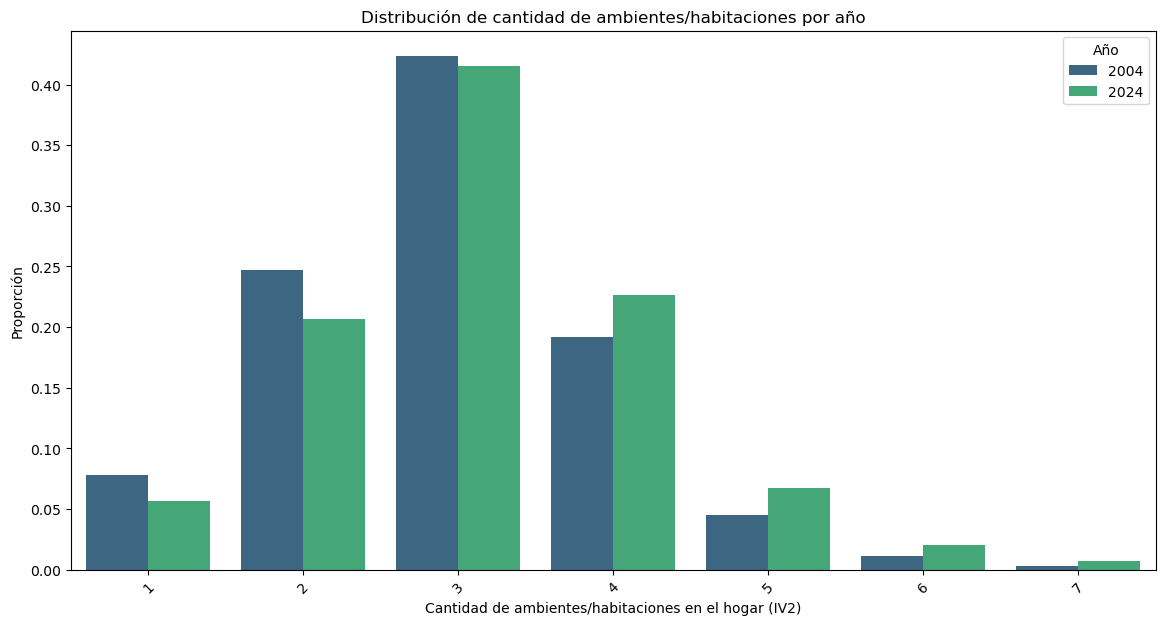

In [578]:
# Calcular las proporciones para 2004
prop_04 = combined_04['IV2'].value_counts(normalize=True).reset_index()
prop_04.columns = ['IV2', 'Proporcion']
prop_04['Year'] = '2004'

# Calcular las proporciones para 2024
prop_24 = combined_24['IV2'].value_counts(normalize=True).reset_index()
prop_24.columns = ['IV2', 'Proporcion']
prop_24['Year'] = '2024'

# Combinar los DataFrames de proporciones
prop_combined = pd.concat([prop_04, prop_24])

# Crear el gráfico de barras
plt.figure(figsize=(14, 7))
sns.barplot(x='IV2', y='Proporcion', hue='Year', data=prop_combined, palette='viridis')

# Personalizar el gráfico
plt.title('Distribución de cantidad de ambientes/habitaciones por año')
plt.xlabel('Cantidad de ambientes/habitaciones en el hogar (IV2)')
plt.ylabel('Proporción')
plt.legend(title='Año')
plt.xticks(rotation=45)
plt.show()


C:\Users\magda\AppData\Local\Temp\ipykernel_10220\1051174072.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='IV2', y='Proporción', data=ambientes04, palette='viridis')


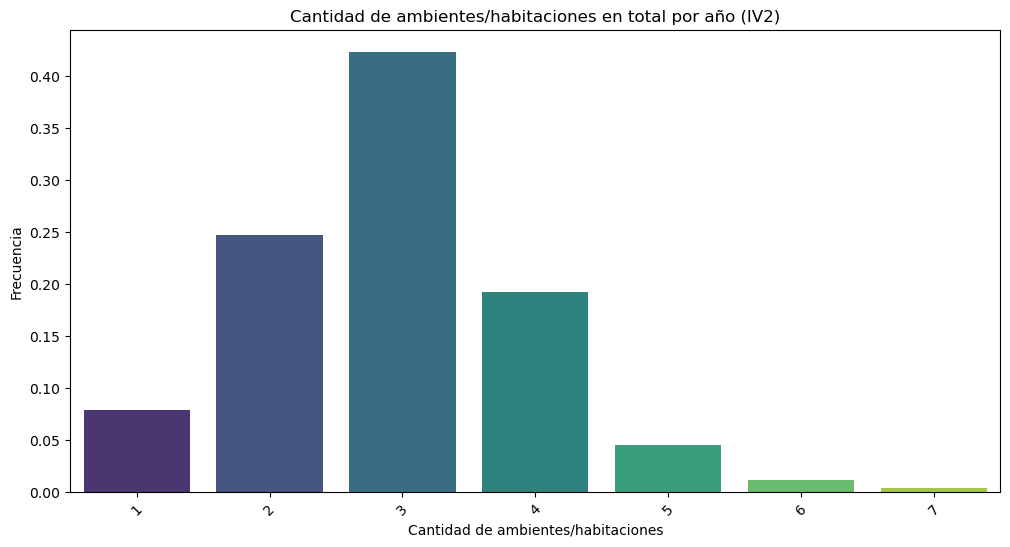

In [ ]:
# #Grafico de IV2: Ambientes/habitaciones en total 
# ambientes04 = combined_04['IV2'].value_counts().reset_index()
# ambientes04.columns = ['IV2', 'Count']
# total_muestra = len(combined_04_total)

# # Calcular la proporción de cada respuesta
# ambientes04['Proporción'] = round(ambientes04['Count'] / total_muestra, 4)

# plt.figure(figsize=(12, 6))
# sns.barplot(x='IV2', y='Proporción', data=ambientes04, palette='viridis')

# # Personalizar el gráfico
# plt.title('Cantidad de ambientes/habitaciones en total por año (IV2)')
# plt.xlabel('Cantidad de ambientes/habitaciones')
# plt.ylabel('Proporción de la muestra')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# #Para la base 2004, reemplazo los valores de texto de las variables binarias a 0 y 1 para ya usarlas como dummies. 
# reemplazosbinarias = {
#     "Sí" : 1, 
#     "No" : 0, 
#     "S" : 1, 
#     "N" : 0, 
#     "Varón" : 1, 
#     "Mujer" : 0
# }

# combined_04 = combined_04.applymap(lambda x: reemplazosbinarias.get(x, x))

C:\Users\magda\AppData\Local\Temp\ipykernel_10220\2471652254.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='II7', y='Count', data=tenencia, palette='viridis')


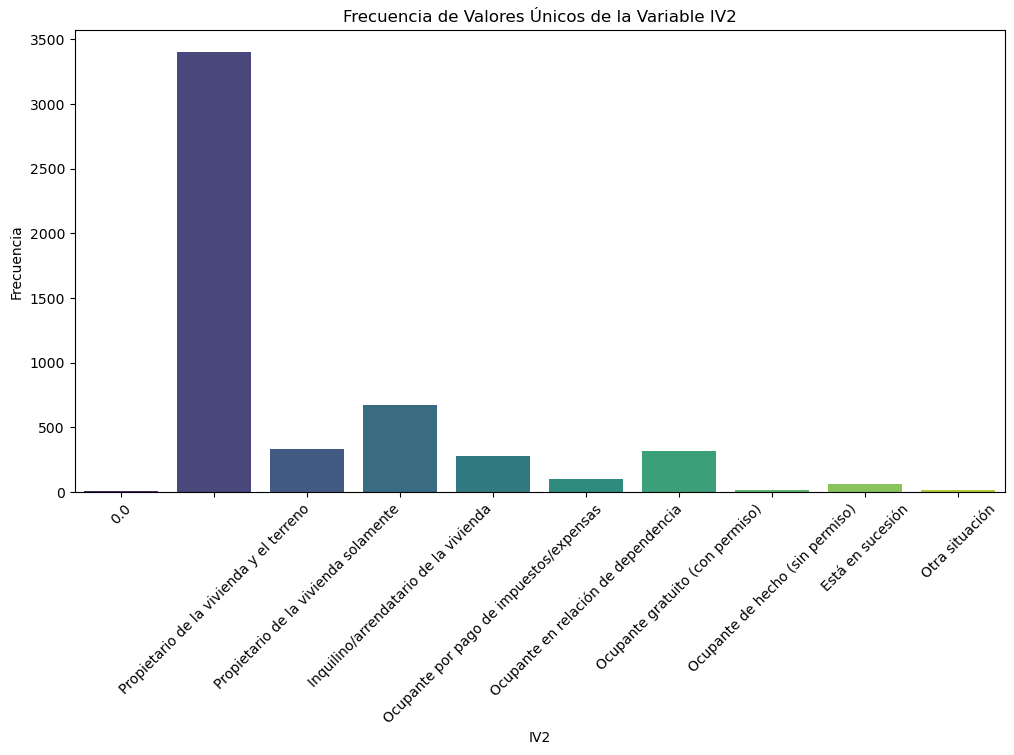

In [ ]:
# #Grafico de IV2: Ambientes/habitaciones en total 
# tenencia = combined_04_total['II7'].value_counts().reset_index()
# tenencia.columns = ['II7', 'Count']

# plt.figure(figsize=(12, 6))
# sns.barplot(x='II7', y='Count', data=tenencia, palette='viridis')

# # Personalizar el gráfico
# plt.title('Frecuencia de Valores Únicos de la Variable IV2')
# plt.xlabel('IV2')
# plt.ylabel('Frecuencia')
# plt.xticks(rotation=45)
# plt.show()

In [581]:
reemplazotenencia = {
    "Propietario de la vivienda y el terreno": 1,
    "Propietario de la vivienda solamente": 2,
    "Inquilino/arrendatario de la vivienda": 3,
    "Ocupante por pago de impuestos/expensas": 4,
    "Ocupante en relación de dependencia": 5,
    "Ocupante gratuito (con permiso)": 6,
    "Ocupante de hecho (sin permiso)": 7,
    "Está en sucesión": 8,
    "Otra situación": 9
}

combined_04_total = combined_04_total.applymap(lambda x: reemplazotenencia.get(x, x))

C:\Users\magda\AppData\Local\Temp\ipykernel_10220\1760542856.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  combined_04_total = combined_04_total.applymap(lambda x: reemplazotenencia.get(x, x))


In [582]:
# II7: Regimen de tenencia
# Contar la frecuencia de cada respuesta
tenencia04 = combined_04_total['II7'].value_counts().reset_index()
tenencia04.columns = ['II7', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_04_total)

# Calcular la proporción de cada respuesta
tenencia04['Proporción'] = round(tenencia04['Frecuencia'] / total_muestra, 4)

tenencia04
# Crear el gráfico de barras
# plt.figure(figsize=(10, 6))
# sns.barplot(x='II7', y='Proporción', data=frequency, palette='viridis')

# # Personalizar el gráfico
# plt.title('Proporción de Respuestas para la Variable II7')
# plt.xlabel('Respuesta II7')
# plt.ylabel('Proporción')
# plt.show()



,II7,Frecuencia,Proporción
0,1.0,3391,0.6535
1,3.0,666,0.1283
2,2.0,334,0.0644
3,6.0,316,0.0609
4,4.0,277,0.0534
5,5.0,99,0.0191
6,8.0,63,0.0121
7,7.0,20,0.0039
8,9.0,15,0.0029
9,0.0,8,0.0015


In [461]:
tenencia24 = combined_24_total['II7'].value_counts().reset_index()
tenencia24.columns = ['II7', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_24_total)

# Calcular la proporción de cada respuesta
tenencia24['Proporción'] = round(tenencia24['Frecuencia'] / total_muestra, 4)

tenencia24

,II7,Frecuencia,Proporción
0,1,2600,0.6193
1,3,794,0.1891
2,2,325,0.0774
3,6,301,0.0717
4,4,101,0.0241
5,8,49,0.0117
6,7,12,0.0029
7,5,7,0.0017
8,9,7,0.0017
9,0,2,0.0005


In [ ]:
# # Calcular las proporciones para 2004
# prop_04 = combined_04_total['II7'].value_counts(normalize=True).reset_index()
# prop_04.columns = ['II7', 'Proporcion']
# prop_04['Year'] = '2004'

# # Calcular las proporciones para 2024
# prop_24 = combined_24_total['II7'].value_counts(normalize=True).reset_index()
# prop_24.columns = ['II7', 'Proporcion']
# prop_24['Year'] = '2024'

# # Combinar los DataFrames de proporciones
# prop_combined = pd.concat([prop_04, prop_24])

# # Crear el gráfico de barras
# plt.figure(figsize=(14, 7))
# sns.barplot(x='II7', y='Proporcion', hue='Year', data=prop_combined, palette='viridis')

# # Personalizar el gráfico
# plt.title('Distribución de cantidad de ambientes/habitaciones por año')
# plt.xlabel('Cantidad de ambientes/habitaciones en el hogar (IV2)')
# plt.ylabel('Proporción')
# plt.legend(title='Año')
# plt.xticks(rotation=45)
# plt.show()

In [ ]:
# import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Calcular las proporciones para 2004
# prop_04 = combined_04_total['II7'].value_counts(normalize=True).reset_index()
# prop_04.columns = ['II7', 'Proporcion']
# prop_04['Year'] = '2004'

# # Calcular las proporciones para 2024
# prop_24 = combined_24_total['II7'].value_counts(normalize=True).reset_index()
# prop_24.columns = ['II7', 'Proporcion']
# prop_24['Year'] = '2024'

# # Combinar los DataFrames de proporciones
# prop_combined = pd.concat([prop_04, prop_24])

# # Crear el gráfico de barras horizontal
# plt.figure(figsize=(14, 7))
# sns.barplot(y='II7', x='Proporcion', hue='Year', data=prop_combined, palette='viridis', orient='h')

# # Personalizar el gráfico
# plt.title('Distribución de cantidad de ambientes/habitaciones por año')
# plt.ylabel('Cantidad de ambientes/habitaciones en el hogar (II7)')
# plt.xlabel('Proporción')
# plt.legend(title='Año')
# plt.yticks(rotation=0)
# plt.show()


In [462]:
ingreso04 = combined_04_total['V1'].value_counts().reset_index()
ingreso04.columns = ['V1', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_04_total)

# Calcular la proporción de cada respuesta
ingreso04['Proporción'] = round(ingreso04['Frecuencia'] / total_muestra, 4)

ingreso04

,V1,Frecuencia,Proporción
0,Sí,4947,0.9495
1,No,263,0.0505


In [463]:
ingreso24 = combined_24_total['V1'].value_counts().reset_index()
ingreso24.columns = ['V1', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_24_total)

# Calcular la proporción de cada respuesta
ingreso24['Proporción'] = round(ingreso24['Frecuencia'] / total_muestra, 4)

ingreso24

,V1,Frecuencia,Proporción
0,1,4024,0.9586
1,2,148,0.0353
2,9,26,0.0062


In [464]:
despido04 = combined_04_total['V3'].value_counts().reset_index()
despido04.columns = ['V3', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_04_total)

# Calcular la proporción de cada respuesta
despido04['Proporción'] = round(despido04['Frecuencia'] / total_muestra, 4)

despido04

,V3,Frecuencia,Proporción
0,No,5188,0.9958
1,Sí,18,0.0035
2,Ns./Nr.,4,0.0008


In [465]:
despido24 = combined_24_total['V3'].value_counts().reset_index()
despido24.columns = ['V3', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_24_total)

# Calcular la proporción de cada respuesta
despido24['Proporción'] = round(despido24['Frecuencia'] / total_muestra, 4)

despido24

,V3,Frecuencia,Proporción
0,2,4146,0.9876
1,1,26,0.0062
2,9,26,0.0062


In [467]:
tipovivienda04 = combined_04_total['IV1'].value_counts().reset_index()
tipovivienda04.columns = ['IV1', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_04_total)

# Calcular la proporción de cada respuesta
tipovivienda04['Proporción'] = round(tipovivienda04['Frecuencia'] / total_muestra, 4)

tipovivienda04

,IV1,Frecuencia,Proporción
0,Casa,3635,0.6977
1,Departamento,1509,0.2896
2,Pieza de inquilinato,30,0.0058
3,Otro,22,0.0042
4,Pieza en hotel/pensión,14,0.0027


In [591]:
combined_04_total['IV1'].value_counts()

IV1
Casa                      3618
Departamento              1505
Pieza de inquilinato        30
Otro                        22
Pieza en hotel/pensión      14
Name: count, dtype: int64

In [466]:
tipovivienda24 = combined_24_total['IV1'].value_counts().reset_index()
tipovivienda24.columns = ['IV1', 'Frecuencia']
# Calcular el tamaño total de la muestra
total_muestra = len(combined_24_total)

# Calcular la proporción de cada respuesta
tipovivienda24['Proporción'] = round(tipovivienda24['Frecuencia'] / total_muestra, 4)

tipovivienda24

,IV1,Frecuencia,Proporción
0,1,3097,0.7377
1,2,1070,0.2549
2,4,19,0.0045
3,6,8,0.0019
4,3,2,0.0005
5,5,2,0.0005


## 5. Clasificacion y regularizacion

#### Armado de base, separación train-test, estandarización

In [655]:
#FILTRAR PERSONAS Q NO RESPONDIERON ESTADO=0
#ESTADO: 0 = Entrevista individual no realizada (no respuesta al cuestionario individual)
    # 1 = Ocupado
    # 2 = Desocupado
    # 3 = Inactivo
    # 4 = Menor de 10 años

# largo_04 = len (combined_04)
# largo_24 = len (combined_24)

datos_04 = combined_04[combined_04['ESTADO'] != 0]
datos_24 = combined_24 [combined_24 ['ESTADO'] !=0]

# print (f'cant original 04',largo_04)
# print (f'cant nhueva 04', len(datos_04))

# print (f'cant original 24',largo_24)
# print (f'cant nhueva 24', len(datos_24))
# columnas_datos04 = datos_04.columns.tolist()
# columnas_datos04

In [656]:
sacar_pre_lasso = ['CODUSU', 'ANO4', 'TRIMESTRE', 'ESTADO', 'AGLOMERADO', 'COMPONENTE', 'REGION', 'REALIZADA']
datos_04 = datos_04.drop (columns = sacar_pre_lasso)
datos_24 = datos_24.drop (columns = sacar_pre_lasso)

In [657]:
#Drop ns/nr
filas_a_eliminar04 = datos_04[
    datos_04.isin(['Ns./Nr.']).any(axis=1)
].index

In [658]:
filas_a_eliminar24 = datos_24[
    datos_24.isin(['Ns./Nr.']).any(axis=1)
].index

In [659]:
len(filas_a_eliminar04)

0

#### Separación base Respondieron / no respondieron
Problema: En 2004 no hay gente que no haya respondido
- En 2024 hay 40

In [54]:
#ACA HAY QUE DEFINIR LA BASE DE RESPONDIERON Y NO RESPONDIERON PARA CADA AÑO: 

# # DataFrame para las personas con ESTADO = 0
# norespondieron_04 = combined_04[combined_04['ESTADO'] == 0]
# norespondieron_24 = combined_24[combined_24['ESTADO'] == 0]

# # DataFrame para las personas con ESTADO distinto de 0
# respondieron_04 = combined_04[combined_04['ESTADO'] != 0]
# respondieron_24 = combined_24[combined_24['ESTADO'] != 0]

# # Imprimir el número de observaciones en cada DataFrame
# print(f"Total de personas que no respondieron (2004): {len(norespondieron_04)}")
# print(f"Total de personas que respondieron (2004) {len(respondieron_04)}")

# print(f"Total de personas que no respondieron (2024): {len(norespondieron_24)}")
# print(f"Total de personas que respondieron (2024) {len(respondieron_24)}")

In [660]:
# Se separa X e y a partir de la selección de columnas numericas
X_2004 = datos_04.drop(columns=['desocupado'])
y_2004 = datos_04['desocupado']
X_2024 = datos_24.drop(columns=['desocupado'])
y_2024 = datos_24['desocupado']

In [661]:
lista_columns = X_2004.columns.tolist()
lista_columns2 = X_2024.columns.tolist()

solo_en_lista1 = set(lista_columns) - set(lista_columns2)
solo_en_lista2 = set(lista_columns2) - set(lista_columns)
print (solo_en_lista1)
print (solo_en_lista2)

{'VII2_1_98.0', 'IV1_Departamento', 'CH14_02', 'VII2_4_5.0', 'IV9_Dentro de la vivienda', 'CH10_Nunca asistió', 'II9_Compartido con otro/s hogar/es de la misma vivienda', 'V7_No', 'IV6_Por cañería dentro de la vivienda', 'CH08_No paga ni le descuentan', 'VII1_2_10.0', 'CH14_00', 'VII1_2_11.0', 'V8_Ns./Nr.', 'VII1_2_2.0', 'CH03_Otros familiares', 'VII1_2_7.0', 'IV11_A red pública (cloaca)', 'CH12_Primario', 'NIVEL_ED_Secundaria Incompleta', 'CH14_08', 'H15_Sí', 'V18_Ns./Nr.', 'CH12_Secundario', 'CH16_Ns./Nr.', 'IV1_Pieza en hotel/pensión', 'VII2_1_3.0', 'VII1_1_2.0', 'VII2_3_3.0', 'IV4_Baldosa/losa sin cubierta', 'V19_B_No', 'V13_No', 'V21_Ns./Nr.', 'IV12_1_No', 'VII2_1_2.0', 'IV10_Inodoro sin botón/cadena y con arrastre de agua', 'IV3_Mosaico/baldosa/madera/cerámica/alfombra', 'II5_No', 'VII2_1_Otra persona que no vive en el hogar', 'CH12_EGB', 'V17_Ns./Nr.', 'VII1_1_7.0', 'II8_Otro', 'CH14_99', 'CH15_En otra localidad', 'VII1_1_8.0', 'V6_Sí', 'II7_Ocupante en relación de dependencia',

#### Separación Train Test

In [662]:
#Partir la base train test para cada ano. 
#Semilla 101
#agregar columna de unos (1)
x_train24, x_test24, y_train_24, y_test_24 = train_test_split(X_2024, y_2024, test_size=0.3, random_state=101)
x_train04, x_test04, y_train_04, y_test_04 = train_test_split(X_2004, y_2004, test_size=0.3, random_state=101)

# x_train_04 = sm.add_constant(x_train_04) #AGREGO COLUMNA DE UNOS
# x_train_24 = sm.add_constant(x_train_24)

In [663]:
tipos_de_datos = x_train04.dtypes 
print(tipos_de_datos)

NRO_HOGAR               float64
CH06                      int32
P47T                    float64
DECINDR                  object
RDECINDR                 object
                         ...   
NSE_bajo                   bool
NSE_medio                  bool
educacion                 int64
proporcion_educacion    float64
ayuda_social              int64
Length: 280, dtype: object


#### Estandarizar

In [664]:
# Identificar las columnas booleanas, float e int
columnas_a_estandarizar_04 = x_train04.select_dtypes(include=['int64', 'float64']).columns
columnas_a_estandarizar_24 = x_train24.select_dtypes(include=['int64', 'float64']).columns

# Inicializar el estandarizador
sc_04 = StandardScaler()
sc_24 = StandardScaler()

# Estandarizamos las observaciones de entrenamiento
x_train_04_transformed = x_train04.copy()
x_train_04_transformed[columnas_a_estandarizar_04] = sc_04.fit_transform(x_train04[columnas_a_estandarizar_04])

x_train_24_transformed = x_train24.copy()
x_train_24_transformed[columnas_a_estandarizar_24] = sc_24.fit_transform(x_train24[columnas_a_estandarizar_24])

# Estandarizamos las observaciones de test usando el estandarizador ya ajustado
x_test_04_transformed = x_test04.copy()
x_test_04_transformed[columnas_a_estandarizar_04] = sc_04.transform(x_test04[columnas_a_estandarizar_04])

x_test_24_transformed = x_test24.copy()
x_test_24_transformed[columnas_a_estandarizar_24] = sc_24.transform(x_test24[columnas_a_estandarizar_24])

# Estadisticas luego de estandarizar
print(x_train_24_transformed.describe().T)

x_train_04 = x_train_04_transformed
x_test_04 = x_test_04_transformed
x_train_24 = x_train_24_transformed
x_test_24 = x_test_24_transformed


                       count          mean       std       min       25%  \
NRO_HOGAR             3740.0  1.120910e-16  1.000134 -0.025365 -0.025365   
CH06                  3740.0 -8.929280e-17  1.000134 -1.540975 -0.875851   
V2_M                  3740.0 -1.899847e-17  1.000134 -0.294265 -0.294265   
V3_M                  3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V4_M                  3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V5_M                  3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V8_M                  3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V9_M                  3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V10_M                 3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V11_M                 3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V12_M                 3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V18_M                 3740.0  0.000000e+00  0.000000  0.000000  0.000000   
V19_AM      

#### Lasso

In [666]:
#Regresion logistica con penalidad LASSO (todos estos pasos se hacen para cada ano)
#### Regresion logistica para 2004
alpha = 1
log04_lasso = LogisticRegression(penalty='l1', C=(1/alpha), solver='liblinear').fit(x_train_04, y_train_04)
y_test_pred_score_04_lasso = log04_lasso.predict_proba(x_train_04)[:,1]
y_pred_log04_lasso = log04_lasso.predict(x_test_04)


In [667]:
#### Regresion logistica para 2024
log24_lasso = LogisticRegression(penalty='l1', C=(1/alpha), solver='liblinear').fit(x_train_24, y_train_24)
y_test_pred_score_24_lasso = log24_lasso.predict_proba(x_train_24)[:,1]
y_pred_log24_lasso = log24_lasso.predict(x_test_24)

Matriz de confusion (Reg Log LASSO 2004)
 [[1717   21]
 [ 111   20]]

AUC Reg Log (2004): 0.5703


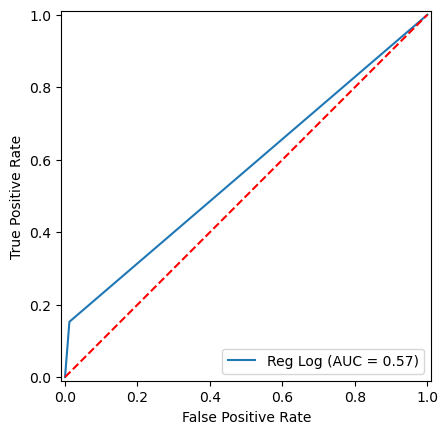

La accuracy del modelo (Reg Log LASSO 2004) es: 0.9294


In [668]:
#### Medidas de precision Regresion logistica LASSO para 2004
#Matriz de confusion
conflog04_lasso = confusion_matrix(y_test_04, y_pred_log04_lasso) 
print("Matriz de confusion (Reg Log LASSO 2004)\n", conflog04_lasso)

#AUC
auc_log04_lasso = roc_auc_score(y_test_04, y_pred_log04_lasso)
print('\nAUC Reg Log (2004): %.4f' %auc_log04_lasso)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_log04_lasso)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log04_lasso, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

# #MSE
# ecm_a1_l04 = mean_squared_error(y_test_04, y_pred_log04_lasso)
# print("Error cuadrático medio:", ecm_a1_l04) 

#Accuracy
accuracy_log04_lasso = accuracy_score(y_test_04, y_pred_log04_lasso)
print("La accuracy del modelo (Reg Log LASSO 2004) es: %.4f" %accuracy_log04_lasso)

Matriz de confusion (Reg Log LASSO 2024)
 [[1521    3]
 [  60   19]]

AUC Reg Log LASSO (2024): 0.6193


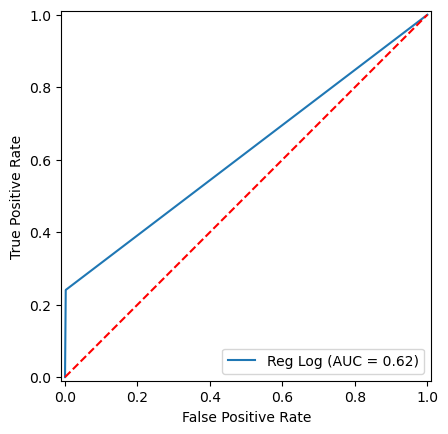

La accuracy del modelo (Reg Log LASSO 2024) es: 0.9607


In [669]:
#### Medidas de precision Regresion logistica LASSO para 2024
#Matriz de confusion
conflog24_lasso = confusion_matrix(y_test_24, y_pred_log24_lasso) 
print("Matriz de confusion (Reg Log LASSO 2024)\n", conflog24_lasso)

#AUC
auc_log24_lasso = roc_auc_score(y_test_24, y_pred_log24_lasso)
print('\nAUC Reg Log LASSO (2024): %.4f' %auc_log24_lasso)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_log24_lasso)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log24_lasso, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

# #MSE
# ecm_a1_l24 = mean_squared_error(y_test_24, y_pred_log24_lasso)
# print("Error cuadrático medio:", ecm_a1_l24) 

#Accuracy
accuracy_log24_lasso = accuracy_score(y_test_24, y_pred_log24_lasso)
print("La accuracy del modelo (Reg Log LASSO 2024) es: %.4f" %accuracy_log24_lasso)

#### Ridge

In [670]:
#Regresion logistica con penalidad ridge (todos estos pasos se hacen para cada ano)
#### Regresion logistica para 2004
alpha = 1
log04_ridge = LogisticRegression(penalty='l2', C=(1/alpha), solver='liblinear').fit(x_train_04, y_train_04)
y_test_pred_score_04_ridge = log04_ridge.predict_proba(x_train_04)[:,1]
y_pred_log04_ridge = log04_ridge.predict(x_test_04)

#### Regresion logistica para 2024
log24_ridge = LogisticRegression(penalty='l2', C=(1/alpha), solver='liblinear').fit(x_train_24, y_train_24)
y_test_pred_score_24_ridge = log24_ridge.predict_proba(x_train_24)[:,1]
y_pred_log24_ridge = log24_ridge.predict(x_test_24)

Matriz de confusion (Reg Log ridge 2004)
 [[1714   24]
 [ 107   24]]

AUC Reg Log ridge (2004): 0.5847


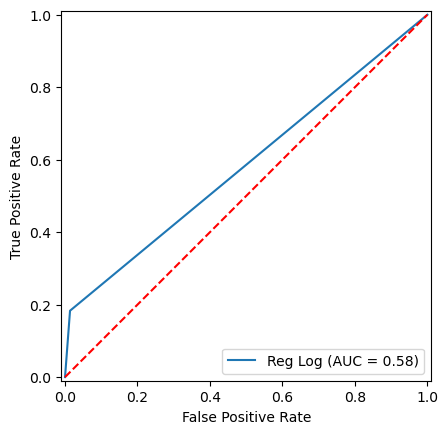

La accuracy del modelo (Reg Log ridge 2004) es: 0.9299


In [671]:
#### Medidas de precision Regresion logistica ridge para 2004
#Matriz de confusion
conflog04_ridge = confusion_matrix(y_test_04, y_pred_log04_ridge) 
print("Matriz de confusion (Reg Log ridge 2004)\n", conflog04_ridge)

#AUC
auc_log04_ridge = roc_auc_score(y_test_04, y_pred_log04_ridge)
print('\nAUC Reg Log ridge (2004): %.4f' %auc_log04_ridge)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_04, y_pred_log04_ridge)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log04_ridge, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

# #MSE
# ecm_a1_r04 = mean_squared_error(y_test_04, y_pred_log04_ridge)
# print("Error cuadrático medio:", ecm_a1_r04)  

#Accuracy
accuracy_log04_ridge = accuracy_score(y_test_04, y_pred_log04_ridge)
print("La accuracy del modelo (Reg Log ridge 2004) es: %.4f" %accuracy_log04_ridge)

Matriz de confusion (Reg Log ridge 2024)
 [[1714   24]
 [ 107   24]]

AUC Reg Log ridge (2024): 0.5686


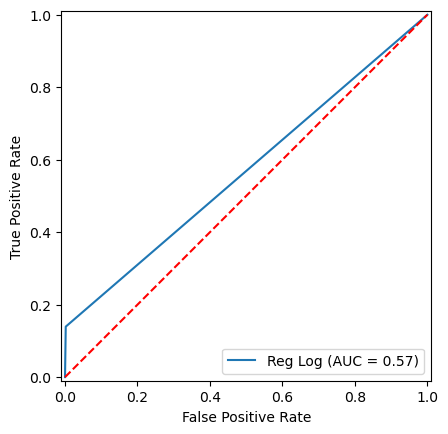

La accuracy del modelo (Reg Log ridge 2024) es: 0.9557


In [672]:
#### Medidas de precision Regresion logistica ridge para 2024
#Matriz de confusion
conflog24_ridge = confusion_matrix(y_test_24, y_pred_log24_ridge) 
print("Matriz de confusion (Reg Log ridge 2024)\n", conflog04_ridge)

#AUC
auc_log24_ridge = roc_auc_score(y_test_24, y_pred_log24_ridge)
print('\nAUC Reg Log ridge (2024): %.4f' %auc_log24_ridge)

#Curva ROC
fpr, tpr, thresholds = roc_curve(y_test_24, y_pred_log24_ridge)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc_log24_ridge, estimator_name='Reg Log')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

# #MSE
# ecm_a1_r24 = mean_squared_error(y_test_24, y_pred_log24_ridge)
# print("Error cuadrático medio:", ecm_a1_r24) 

#Accuracy
accuracy_log24_ridge = accuracy_score(y_test_24, y_pred_log24_ridge)
print("La accuracy del modelo (Reg Log ridge 2024) es: %.4f" %accuracy_log24_ridge)

#### Selección de alpha

In [673]:
# Cross validation para elegir el alpha para los metodos de regularizacion
from sklearn.linear_model import LogisticRegressionCV

#LASSO 2004
# Definir los valores de C como el inverso de los valores de λ en el rango especificado 
alphas = 10 ** np.array([*range(-5, 6)], dtype=float) # Genera 10^n para n en [-5, -4, ..., 4, 5] 
Cs = 1 / alphas

# Crear el modelo de regresión logística con validación cruzada y penalización L1
log_lasso_cv_04 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l1', solver='saga', scoring='accuracy', refit=True, max_iter=10000, n_jobs=-1)

# Entrenar el modelo
log_lasso_cv_04.fit(x_train_04, y_train_04)

# Imprimir el mejor valor de C (inverso de alpha)
print("Mejor valor de C:", log_lasso_cv_04.C_[0])

print("El mejor valor de alpha:", (1/log_lasso_cv_04.C_[0]))

# # Hacer predicciones (opcional)
# y_pred_ = log_lasso_cv_04.predict(x_test_04)

#Resultados con alphas = 10 ** np.array([*range(-3, 3)], dtype=float) 
    #Mejor valor de C: 0.1
    #El mejor valor de alpha: 10.0


Mejor valor de C: 0.01
El mejor valor de alpha: 100.0


In [68]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Recoger los valores de accuracy para cada partición y lambda
# results = []

# for i, C in enumerate(log_lasso_cv_04.Cs_):
#     # Crear un modelo de regresión logística con el valor de C actual
#     log_lasso = LogisticRegression(penalty='l1', solver='saga', C=C, max_iter=1000)
#     scores = cross_val_score(log_lasso, x_train_04, y_train_04, cv=10, scoring='accuracy')
#     for score in scores:
#         results.append((1/C, score))

# # Convertir los resultados a un DataFrame
# df_results = pd.DataFrame(results, columns=['lambda', 'accuracy'])

# # Crear el box plot utilizando seaborn
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='lambda', y='accuracy', data=df_results)
# plt.yscale("log")
# plt.title('Distribución del accuracy para cada valor de lambda')
# plt.xlabel('Valor de lambda')
# plt.ylabel('Accuracy')
# plt.xticks(rotation=45)
# plt.show()


In [675]:
#LASSO 2024
alphas = 10 ** np.array([*range(-5, 6)], dtype=float) # Genera 10^n para n en [-5, -4, ..., 4, 5] 
Cs = 1 / alphas

# Crear el modelo de regresión logística con validación cruzada y penalización L1
log_lasso_cv_24 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l1', solver='saga', scoring='accuracy', refit=True, max_iter=10000, n_jobs=-1)

# Entrenar el modelo
log_lasso_cv_24.fit(x_train_24, y_train_24)

# Imprimir el mejor valor de C (inverso de alpha)
print("Mejor valor de C:", log_lasso_cv_24.C_[0])

print("El mejor valor de alpha:", (1/log_lasso_cv_24.C_[0]))

Mejor valor de C: 99999.99999999999
El mejor valor de alpha: 1e-05


In [ ]:
#Ridge 2004
alphas = 10 ** np.array([*range(-5, 6)], dtype=float) # Genera 10^n para n en [-5, -4, ..., 4, 5] 
Cs = 1 / alphas

# Crear el modelo de regresión logística con validación cruzada y penalización L2
log_ridge_cv_04 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l2', solver='saga', scoring='accuracy', refit=True, max_iter=10000, n_jobs=-1)

# Entrenar el modelo
log_ridge_cv_04.fit(x_train_04, y_train_04)

# Imprimir el mejor valor de C (inverso de alpha)
print("Mejor valor de C:", log_ridge_cv_04.C_[0])

print("El mejor valor de alpha:", (1/log_ridge_cv_04.C_[0]))

# # Hacer predicciones (opcional)
# y_pred_ = log_lasso_cv_04.predict(x_test_04)



In [ ]:
#Ridge 2024
alphas = 10 ** np.array([*range(-5, 6)], dtype=float) # Genera 10^n para n en [-5, -4, ..., 4, 5] 
Cs = 1 / alphas

# Crear el modelo de regresión logística con validación cruzada y penalización L2
log_ridge_cv_24 = LogisticRegressionCV(Cs=Cs, cv=10, penalty='l2', solver='saga', scoring='accuracy', refit=True, max_iter=10000, n_jobs=-1)

# Entrenar el modelo
log_ridge_cv_24.fit(x_train_24, y_train_24)

# Imprimir el mejor valor de C (inverso de alpha)
print("Mejor valor de C:", log_ridge_cv_24.C_[0])

print("El mejor valor de alpha:", (1/log_ridge_cv_24.C_[0]))

In [ ]:
#boxplot usando seaborn: distribucion del error de prediccion para cada alpha

#boxplot usando seaborn: distribucion del error de prediccion para cada alpha
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Supongamos que tienes los resultados de la cross-validation en un DataFrame
# Donde 'lambda_values' es una lista de los valores de lambda probados
# 'accuracies' es una lista de listas o un DataFrame con los accuracies para cada lambda

# Ejemplo de datos simulados:
lambda_values = [0.1, 1, 10, 100]  # Valores de lambda
accuracies = [
    [0.80, 0.82, 0.81, 0.83],  # Accuracy para lambda=0.1
    [0.75, 0.76, 0.77, 0.75],  # Accuracy para lambda=1
    [0.60, 0.62, 0.61, 0.63],  # Accuracy para lambda=10
    [0.55, 0.57, 0.56, 0.54]   # Accuracy para lambda=100
]

# Crear un DataFrame con los resultados
df = pd.DataFrame(accuracies, columns=[f'Fold {i+1}' for i in range(len(accuracies[0]))], index=lambda_values)

# Ahora necesitamos convertir este DataFrame a formato largo para seaborn (usando melt)
df_melted = df.reset_index().melt(id_vars='index', var_name='Fold', value_name='Accuracy')
df_melted.rename(columns={'index': 'Lambda'}, inplace=True)

# Crear el gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Lambda', y='Accuracy', data=df_melted)

# Títulos y etiquetas
plt.title('Distribución del Accuracy para diferentes valores de Lambda (Regresión Logística con Lasso)', fontsize=14)
plt.xlabel('Valor de Lambda', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)


In [ ]:
# line plot 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Supongamos que tienes tus datos X (características) y y (objetivo)
# X = tus datos de características (pandas DataFrame o numpy array)
# y = tus datos de objetivo (vector de etiquetas)

# Valores de lambda (o alpha en sklearn)
lambda_values = [0.1, 1, 10, 100, 1000]  # Diferentes valores de lambda (alpha)
proporcion_ignoradas = []  # Para almacenar la proporción de variables ignoradas

# Supongamos que tienes un modelo Lasso
# X, y = tus datos (asegúrate de tenerlos preparados previamente)

for lambda_val in lambda_values:
    # Ajustar el modelo Lasso con el valor de lambda (alpha)
    lasso = Lasso(alpha=lambda_val)
    lasso.fit(X, y)
 # Contar cuántos coeficientes son exactamente cero
    coef_zeros = np.sum(lasso.coef_ == 0)
    
    # Calcular la proporción de variables ignoradas
    proporcion_ignoradas = coef_zeros / len(lasso.coef_)
    proporcion_ignoradas.append(proporcion_ignoradas)

# Crear un DataFrame con los resultados
df_ignoradas = pd.DataFrame({
    'Lambda': lambda_values,
    'Proporcion_Ignoradas': proporcion_ignoradas
})

# Crear el gráfico de lineplot
plt.figure(figsize=(10, 6))
sns.lineplot(x='Lambda', y='Proporcion_Ignoradas', data=df_ignoradas, marker='o')

# Títulos y etiquetas
plt.title('Proporción de Variables Ignoradas por el Modelo (Regresión Lasso) en función de Lambda', fontsize=14)
plt.xlabel('Valor de Lambda', fontsize=12)
plt.ylabel('Proporción de Variables Ignoradas', fontsize=12)
plt.xscale('log')  # Usar escala logarítmica para los valores de lambda
plt.show()

In [ ]:
#MODELOS LASSO OPTIMOS

#2004

#2024

In [ ]:
#MODELOS RIDGE OPTIMOS

#2004

#2024

In [ ]:
#comparar resultados lasso y ridge 2004 vs 2024